In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from ot import emd2  # Wasserstein distance computation
from tqdm import tqdm

%matplotlib widget

# check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
Gaussian Mixture Model

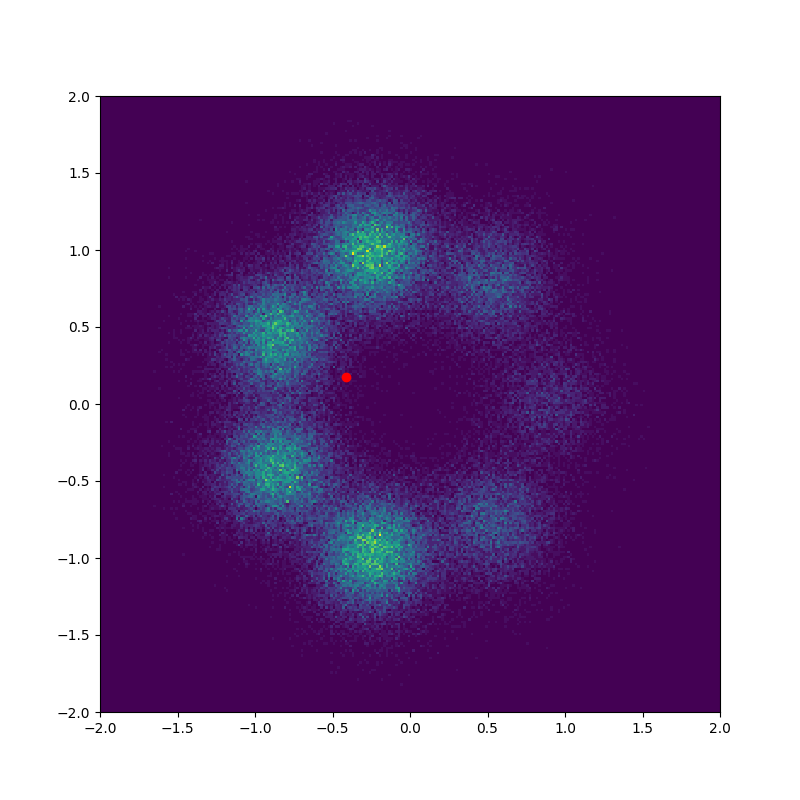

In [2]:
from scipy.stats import multivariate_normal
from sklearn.datasets import make_moons


class DataDistribution:
    def __init__(self, config):
        self.mu = []
        self.sig = []
        self.L_sig = []
        self.generator = np.random.RandomState(0)
        # get mus from config
        for i in range(len(config['gaussians'])):
            self.mu.append(np.array(config['gaussians'][i]['mu']))
            self.sig.append(np.array(config['gaussians'][i]['cov']))
            self.L_sig.append(np.linalg.cholesky(self.sig[i]))
        self.mu = np.array(self.mu)
        self.sig = np.array(self.sig)
        self.L_sig = np.array(self.L_sig)

    def __call__(self, n_samples=1):
        # sample which gaussian to sample from use random state
        idx = np.random.choice(len(self.mu), n_samples)
        # sample from the chosen gaussian
        
        return self.mu[idx][...,0] + np.einsum("nij, nj->ni", self.L_sig[idx], np.random.randn(n_samples, 2)) #self.L_sig[idx]@np.random.randn(2, n_samples).T)
    
    def sample(self, n_samples=1):
        return self(n_samples)

config = {
'gaussians': [
    {'mu': [[3],[-6]], 'cov': [[1,0.25],[0.25,1]]},
    {'mu': [[-2],[3]], 'cov': [[2,-1.5],[-1.5,2]]},
    {'mu': [[3],[6]], 'cov': [[0.2,-0.1],[-0.1,2]]}
]}

data_dist = DataDistribution(config)

# config for 8 gaussians in a circle
r  = 1
sigma = 5e-2
n_gaussians = 7
config_circle = {
'gaussians': [
    {'mu': [[r*np.cos(2*np.pi*i/n_gaussians)],[r*np.sin(2*np.pi*i/n_gaussians)]], 'cov': [[sigma,0],[0,sigma]]} for i in range(n_gaussians)
]}

gaussian_circle = DataDistribution(config_circle)

# define forward process and degrade data with forward process and noise
class BasicForwardModel:
    def __init__(self, data_distribution, config):
        self.data_dist = data_distribution
        # identity matrix
        self.A = np.array([[1,0],[0,1]])
        # noise level
        self.mu = np.array(config['mu'])
        self.sig = np.diag(np.array(config['cov']))
        self.L_sig = np.linalg.cholesky(self.sig)
    
    def __call__(self, n_samples=1):
        # forward process
        x = self.data_dist(n_samples)
        # forward operator
        y = x@self.A.T
        # add noise
        
        y += (self.L_sig@np.random.randn(2, n_samples)).T + self.mu[None]
        return y
    
    def get_p_y(self, y):
        p_y = []
        for j in range(self.data_dist.mu.shape[0]):
            mu = self.A@self.data_dist.mu[j] + self.mu[:,None]
            sig = self.A@self.data_dist.sig[j]@self.A.T + self.sig
            p_y.append(multivariate_normal.pdf(y, mean=mu[:,0],cov=sig))
        return p_y
    
    def unnormalized_posterior(self, y):
        self.post_mu = []
        self.post_sig = []
        self.post_cholesky = []
        for i in range(self.data_dist.mu.shape[0]):
            mu_data = self.data_dist.mu[i][None]
            sig_data = self.data_dist.sig[i][None]
            mu_post = mu_data + (sig_data @ np.linalg.inv(sig_data + self.sig)) @ (y[...,None] - self.A[None]@mu_data)
            self.post_mu.append(mu_post[0])
            sig_post = sig_data - self.A[None]@sig_data @ np.linalg.inv(sig_data + self.sig) @ self.A[None]@sig_data
            self.post_sig.append(sig_post[0])
            self.post_cholesky.append(np.linalg.cholesky(sig_post[0]))
        self.post_mu = np.array(self.post_mu)
        self.post_sig = np.array(self.post_sig)
        self.post_cholesky = np.array(self.post_cholesky)
    
    def sample_posterior(self, y, n_samples=1):
        self.unnormalized_posterior(y)
        p_y = self.get_p_y(y)
        # sample idx of gaussian with probability p_y
        idx = np.random.choice(self.post_mu.shape[0], n_samples, p=p_y/np.sum(p_y))
        return self.post_mu[idx][...,0] + np.einsum("nij, nj->ni", self.post_cholesky[idx], np.random.randn(n_samples, 2))

    def set_A(self, A):
        self.A = A


class MoonDataset:
    def __init__(noise=0.05):
        self.noise = noise

    def __call__(self, n_samples=1):
        x = make_moons(n_samples, noise=self.noise)[0]
        x = torch.tensor(x).type(torch.float32)
        return x
    
    def sample(self, n_samples=1):
        return self(n_samples)
    
measurement_model = BasicForwardModel(gaussian_circle, {'mu': [0,0], 'cov': [0.5,0.5]})
# projection on x-axis
measurement_model.set_A(np.array([[1,0],[0,0]]))
# plot posterior samples
# 1. sample measurement
y = measurement_model(1)
y_samples = measurement_model(100000)
n_samples = 100000
post_samples = measurement_model.sample_posterior(y, n_samples)
# plot measurement_model.post_mu
# aspect ratio 1:1
plt.figure(figsize=(8,8))
# plot
plt.hist2d(post_samples[:,0],post_samples[:,1],bins=256, range=[[-2, 2], [-2, 2]])
plt.scatter(y[0,0],y[0,1],c='r')
plt.show()


# Define Network

In [3]:
# define score matching network
from torch import nn
from torch.nn import functional as F
import math

class BasicScoreNet(nn.Module):
    def __init__(self, hidden_size=128):
        super(BasicScoreNet, self).__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, 2)
       
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        # x += self.temporal_embedding(t)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = self.fc6(x)
        return x

    def sample(self, t, x):
        t = torch.ones(x.shape[0],1, device=x.device).type(torch.float32)*t
        x = torch.cat([x, t],1)
        return self.forward(x)


    def temporal_embedding(self, timesteps, max_period=1000):
        """
        Generate temporal embeddings for diffusion models.
        
        Args:
            timesteps (torch.Tensor): Tensor of shape (batch_size,) containing the time steps.
            embedding_dim (int): Dimension of the embedding vector.
            max_period (float): Maximum period for the sinusoidal functions.
            device (str): The device to place the tensor on ('cpu' or 'cuda').

        Returns:
            torch.Tensor: Temporal embedding tensor of shape (batch_size, embedding_dim).
        """
        # Ensure timesteps are a tensor of shape (batch_size,)
        timesteps = timesteps.to(device).float().unsqueeze(1)
        
        # Compute the sinusoidal frequencies
        half_dim = self.hidden_size // 2
        exponent = torch.arange(half_dim, device=device).float() / half_dim
        frequencies = max_period ** (-exponent)
        
        # Compute the sinusoidal embedding
        angles = timesteps * frequencies  # Shape: (batch_size, half_dim)
        embedding = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)  # Shape: (batch_size, embedding_dim)
        
        return embedding
    



## DDPM Training

In [9]:
# DDPM / VP score matching
beta_min = 1e-4
beta_max = 0.02
num_steps = 1000
betas = torch.linspace(beta_min,beta_max,num_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
training_iterations = 10000

batch_size = 2048
denoiser = BasicScoreNet(hidden_size=128).to(device)
optimizer = torch.optim.AdamW(denoiser.parameters(),1e-4,(.9,.999),weight_decay=1e-3)
data = gaussian_circle
loss_avg = []
for i in range(training_iterations):
    # sample timestep
    t = torch.randint(0,num_steps,(batch_size,)).to(device)
    alpha_cumprod_t = alpha_cumprod[t]
    # sample datapoint
    x = torch.tensor(data.sample(batch_size)).type(torch.float32).to(device)
    # sample noise
    eps = torch.randn(batch_size,2).to(device)
    # noise sample
    x_t = alpha_cumprod_t[:,None] * x + eps * (1-alpha_cumprod_t[:,None])
    # compute scores
    eps_pred = denoiser(torch.cat([x_t, t[:,None]/1000], 1))
    # eps_pred = denoiser(x_t, t)
    # compute loss
    loss = torch.mean((eps_pred - eps)**2)
    loss_avg.append(loss.item())
    if len(loss_avg) > 100:
        loss_avg.pop(0)
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0: print(sum(loss_avg)/len(loss_avg))

print('done')
print(f"loss: {loss.item()}")


0.9788929224014282
0.8168584483861924
0.29985958635807036
0.28058437019586563
0.27092502295970916
0.26555245205760003
0.25329422190785406
0.24428571492433548
0.23578627303242683
0.23176335230469702
0.2291517113149166
0.2294607049226761
0.22429898053407668
0.2268688201904297
0.22767822682857514
0.225467716306448
0.22679982110857963
0.22389983981847764
0.22540103554725646
0.22601501852273942
0.2249717827141285
0.22625265657901764
0.22515019342303277
0.22488502353429796
0.22668808817863464
0.22273348107934
0.22239573821425437
0.22411368563771247
0.22527418330311774
0.2213920372724533
0.22570403441786765
0.22239417418837548
0.22340307697653772
0.2220926409959793
0.22196844831109047
0.22329683393239974
0.2240033333003521
0.22409663304686547
0.22278156131505966
0.2240447862446308
0.22101781517267227
0.2226044361293316
0.22036608725786208
0.22149304866790773
0.22123729720711707
0.22159530803561212
0.22447581976652145
0.22380895137786866
0.2226981146633625
0.22205259442329406
0.223401542603969

## Flow Matching Training

In [19]:

# Flow Matching
training_iterations = 10000

batch_size = 2048
denoiser_flow = BasicScoreNet(hidden_size=128).to(device)
optimizer = torch.optim.AdamW(denoiser_flow.parameters(),1e-3,(.9,.999),weight_decay=1e-2)
sig_min = 1e-4
data = gaussian_circle
for i in tqdm(range(training_iterations)):
    # sample timestep
    t = torch.rand((batch_size,)).to(device)[:, None]
    # sample datapoint
    x1 = torch.tensor(data.sample(batch_size)).type(torch.float32).to(device)
    # sample noise
    x0 = torch.randn(batch_size, 2).to(device)
    # interpolate between samples
    x_t = (sig_min + (1 - sig_min) * t) * x1 + (1 - t) * x0
    # compute drift v
    v = denoiser_flow(torch.cat([x_t, t], 1))
    # compute loss
    loss = torch.mean((v - (x1 - x0 * (1 - sig_min))) ** 2)
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0:
        tqdm.write(f"Loss: {loss.item()}")

print('done')
print(f"loss: {loss.item()}")


  0%|          | 30/10000 [00:00<00:35, 284.55it/s]

Loss: 1.5882940292358398


  1%|▏         | 149/10000 [00:00<00:25, 383.04it/s]

Loss: 1.1654523611068726


  3%|▎         | 274/10000 [00:00<00:24, 400.09it/s]

Loss: 1.1052796840667725


  4%|▎         | 356/10000 [00:00<00:24, 399.96it/s]

Loss: 1.123950719833374


  5%|▍         | 481/10000 [00:01<00:23, 406.33it/s]

Loss: 1.0690574645996094


  6%|▌         | 564/10000 [00:01<00:23, 401.32it/s]

Loss: 1.1233079433441162


  6%|▋         | 644/10000 [00:01<00:25, 364.29it/s]

Loss: 1.1301250457763672


  8%|▊         | 764/10000 [00:01<00:24, 384.83it/s]

Loss: 1.1341519355773926


  8%|▊         | 847/10000 [00:02<00:22, 398.79it/s]

Loss: 1.1172173023223877


 10%|▉         | 972/10000 [00:02<00:23, 383.64it/s]

Loss: 1.1450704336166382


 11%|█         | 1052/10000 [00:02<00:22, 391.33it/s]

Loss: 1.154149055480957


 12%|█▏        | 1178/10000 [00:03<00:21, 406.68it/s]

Loss: 1.1098061800003052


 13%|█▎        | 1260/10000 [00:03<00:22, 395.72it/s]

Loss: 1.097294807434082


 13%|█▎        | 1341/10000 [00:03<00:21, 396.23it/s]

Loss: 1.049095630645752


 15%|█▍        | 1462/10000 [00:03<00:22, 387.98it/s]

Loss: 1.117055892944336


 15%|█▌        | 1542/10000 [00:03<00:21, 389.45it/s]

Loss: 1.0915091037750244


 17%|█▋        | 1669/10000 [00:04<00:20, 402.71it/s]

Loss: 1.1077609062194824


 18%|█▊        | 1753/10000 [00:04<00:20, 405.38it/s]

Loss: 1.0880515575408936


 19%|█▉        | 1879/10000 [00:04<00:20, 402.15it/s]

Loss: 1.0978517532348633


 20%|█▉        | 1963/10000 [00:05<00:19, 402.37it/s]

Loss: 1.1083407402038574


 20%|██        | 2046/10000 [00:05<00:19, 403.25it/s]

Loss: 1.1015946865081787


 22%|██▏       | 2171/10000 [00:05<00:20, 387.83it/s]

Loss: 1.1076112985610962


 23%|██▎       | 2252/10000 [00:05<00:19, 391.18it/s]

Loss: 1.1268540620803833


 24%|██▍       | 2375/10000 [00:06<00:19, 400.78it/s]

Loss: 1.0794920921325684


 25%|██▍       | 2459/10000 [00:06<00:18, 399.65it/s]

Loss: 1.0977675914764404


 25%|██▌       | 2541/10000 [00:06<00:18, 395.80it/s]

Loss: 1.0921016931533813


 27%|██▋       | 2666/10000 [00:06<00:18, 405.66it/s]

Loss: 1.1081470251083374


 27%|██▋       | 2748/10000 [00:06<00:18, 395.23it/s]

Loss: 1.1170740127563477


 29%|██▊       | 2869/10000 [00:07<00:19, 373.56it/s]

Loss: 1.120786190032959


 30%|██▉       | 2951/10000 [00:07<00:17, 392.23it/s]

Loss: 1.084360957145691


 31%|███       | 3079/10000 [00:07<00:16, 408.04it/s]

Loss: 1.1443369388580322


 32%|███▏      | 3162/10000 [00:08<00:16, 404.56it/s]

Loss: 1.0870932340621948


 32%|███▏      | 3244/10000 [00:08<00:16, 397.88it/s]

Loss: 1.1071674823760986


 34%|███▎      | 3369/10000 [00:08<00:16, 404.63it/s]

Loss: 1.12552809715271


 35%|███▍      | 3452/10000 [00:08<00:16, 405.37it/s]

Loss: 1.1106754541397095


 36%|███▌      | 3574/10000 [00:09<00:16, 398.01it/s]

Loss: 1.1209946870803833


 37%|███▋      | 3654/10000 [00:09<00:17, 372.13it/s]

Loss: 1.092703104019165


 38%|███▊      | 3777/10000 [00:09<00:15, 396.75it/s]

Loss: 1.0802266597747803


 39%|███▊      | 3857/10000 [00:09<00:16, 381.48it/s]

Loss: 1.0926308631896973


 40%|███▉      | 3976/10000 [00:10<00:15, 388.30it/s]

Loss: 1.0640287399291992


 41%|████      | 4056/10000 [00:10<00:15, 392.42it/s]

Loss: 1.0713040828704834


 41%|████▏     | 4142/10000 [00:10<00:14, 406.96it/s]

Loss: 1.0540611743927002


 43%|████▎     | 4270/10000 [00:10<00:13, 411.04it/s]

Loss: 1.1257375478744507


 44%|████▎     | 4354/10000 [00:11<00:14, 381.11it/s]

Loss: 1.1053794622421265


 45%|████▍     | 4476/10000 [00:11<00:14, 386.81it/s]

Loss: 1.082109808921814


 46%|████▌     | 4554/10000 [00:11<00:14, 374.26it/s]

Loss: 1.1229456663131714


 47%|████▋     | 4679/10000 [00:11<00:13, 398.67it/s]

Loss: 1.1376274824142456


 48%|████▊     | 4761/10000 [00:12<00:13, 399.82it/s]

Loss: 1.087974190711975


 48%|████▊     | 4843/10000 [00:12<00:12, 397.36it/s]

Loss: 1.0920910835266113


 50%|████▉     | 4969/10000 [00:12<00:12, 408.50it/s]

Loss: 1.0960837602615356


 50%|█████     | 5049/10000 [00:12<00:12, 384.00it/s]

Loss: 1.0511497259140015


 52%|█████▏    | 5177/10000 [00:13<00:11, 408.59it/s]

Loss: 1.0657576322555542


 53%|█████▎    | 5259/10000 [00:13<00:11, 406.60it/s]

Loss: 1.0690943002700806


 54%|█████▍    | 5382/10000 [00:13<00:11, 402.78it/s]

Loss: 1.0769940614700317


 55%|█████▍    | 5466/10000 [00:13<00:11, 406.13it/s]

Loss: 1.0877803564071655


 55%|█████▌    | 5548/10000 [00:14<00:10, 404.76it/s]

Loss: 1.1130789518356323


 57%|█████▋    | 5675/10000 [00:14<00:10, 413.55it/s]

Loss: 1.0265147686004639


 58%|█████▊    | 5758/10000 [00:14<00:10, 405.65it/s]

Loss: 1.1140053272247314


 59%|█████▉    | 5880/10000 [00:14<00:10, 387.32it/s]

Loss: 1.1154457330703735


 60%|█████▉    | 5961/10000 [00:15<00:10, 391.07it/s]

Loss: 1.0884426832199097


 60%|██████    | 6040/10000 [00:15<00:10, 379.74it/s]

Loss: 1.0947612524032593


 62%|██████▏   | 6165/10000 [00:15<00:09, 386.54it/s]

Loss: 1.055275797843933


 62%|██████▏   | 6247/10000 [00:15<00:09, 396.28it/s]

Loss: 1.1224727630615234


 64%|██████▎   | 6374/10000 [00:16<00:08, 410.61it/s]

Loss: 1.0583765506744385


 65%|██████▍   | 6459/10000 [00:16<00:08, 408.50it/s]

Loss: 1.0874265432357788


 65%|██████▌   | 6539/10000 [00:16<00:09, 372.37it/s]

Loss: 1.07444167137146


 67%|██████▋   | 6658/10000 [00:16<00:08, 386.61it/s]

Loss: 1.1356496810913086


 68%|██████▊   | 6783/10000 [00:17<00:07, 403.08it/s]

Loss: 1.092298150062561


 69%|██████▊   | 6867/10000 [00:17<00:07, 403.83it/s]

Loss: 1.075056552886963


 70%|██████▉   | 6950/10000 [00:17<00:07, 406.18it/s]

Loss: 1.0552819967269897


 71%|███████   | 7074/10000 [00:17<00:07, 404.98it/s]

Loss: 1.092811107635498


 72%|███████▏  | 7157/10000 [00:18<00:07, 386.08it/s]

Loss: 1.086803674697876


 73%|███████▎  | 7282/10000 [00:18<00:06, 405.13it/s]

Loss: 1.136277437210083


 74%|███████▎  | 7366/10000 [00:18<00:06, 401.01it/s]

Loss: 1.1085283756256104


 74%|███████▍  | 7449/10000 [00:18<00:06, 403.05it/s]

Loss: 1.0999126434326172


 76%|███████▌  | 7574/10000 [00:19<00:05, 405.69it/s]

Loss: 1.127562165260315


 77%|███████▋  | 7656/10000 [00:19<00:05, 399.49it/s]

Loss: 1.074097752571106


 78%|███████▊  | 7779/10000 [00:19<00:05, 402.64it/s]

Loss: 1.07322359085083


 79%|███████▊  | 7862/10000 [00:19<00:05, 386.10it/s]

Loss: 1.1012388467788696


 79%|███████▉  | 7944/10000 [00:20<00:05, 394.82it/s]

Loss: 1.0785104036331177


 81%|████████  | 8068/10000 [00:20<00:04, 404.09it/s]

Loss: 1.126346230506897


 82%|████████▏ | 8151/10000 [00:20<00:04, 401.66it/s]

Loss: 1.122087836265564


 83%|████████▎ | 8278/10000 [00:21<00:04, 412.26it/s]

Loss: 1.1004235744476318


 84%|████████▎ | 8363/10000 [00:21<00:03, 409.39it/s]

Loss: 1.0813804864883423


 84%|████████▍ | 8445/10000 [00:21<00:03, 407.48it/s]

Loss: 1.1015530824661255


 86%|████████▌ | 8570/10000 [00:21<00:03, 401.98it/s]

Loss: 1.0446057319641113


 87%|████████▋ | 8654/10000 [00:21<00:03, 385.82it/s]

Loss: 1.0731834173202515


 88%|████████▊ | 8774/10000 [00:22<00:03, 384.52it/s]

Loss: 1.1157768964767456


 89%|████████▊ | 8854/10000 [00:22<00:03, 378.89it/s]

Loss: 1.0987002849578857


 90%|████████▉ | 8973/10000 [00:22<00:02, 386.40it/s]

Loss: 1.1065583229064941


 91%|█████████ | 9055/10000 [00:23<00:02, 393.38it/s]

Loss: 1.126863718032837


 92%|█████████▏| 9178/10000 [00:23<00:02, 403.53it/s]

Loss: 1.1123907566070557


 93%|█████████▎| 9262/10000 [00:23<00:01, 382.61it/s]

Loss: 1.057098150253296


 93%|█████████▎| 9341/10000 [00:23<00:01, 387.17it/s]

Loss: 1.0507841110229492


 95%|█████████▍| 9470/10000 [00:24<00:01, 404.44it/s]

Loss: 1.1095210313796997


 96%|█████████▌| 9551/10000 [00:24<00:01, 391.75it/s]

Loss: 1.1625590324401855


 97%|█████████▋| 9674/10000 [00:24<00:00, 395.31it/s]

Loss: 1.0817148685455322


 98%|█████████▊| 9755/10000 [00:24<00:00, 363.29it/s]

Loss: 1.0687458515167236


 99%|█████████▉| 9877/10000 [00:25<00:00, 390.26it/s]

Loss: 1.1109166145324707


100%|█████████▉| 9960/10000 [00:25<00:00, 379.59it/s]

Loss: 1.1079258918762207


100%|██████████| 10000/10000 [00:25<00:00, 392.50it/s]

done
loss: 1.0914125442504883


## DDIM Test Time Guidance


In [13]:
y_measurements = torch.Tensor(measurement_model(100)).to(device)
y = y_measurements[:1]


start point tensor([[ 1.4097, -0.3698]])


Text(0.5, 1.0, 'Density and Trajectory DDIM eta=0.0')

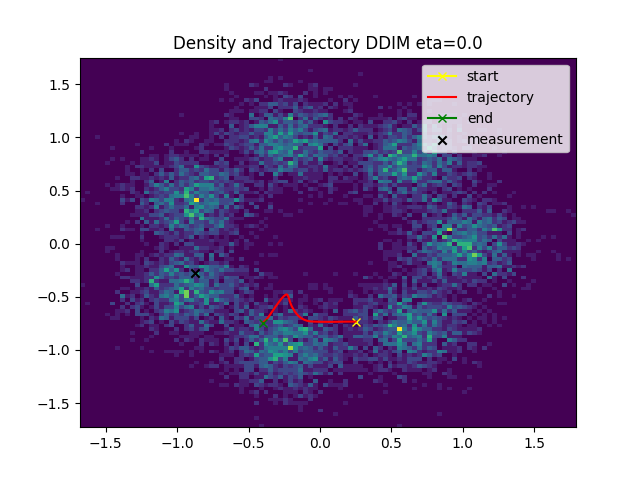

In [14]:

x_t = torch.randn(1,2).to(device)
print("start point", x_t)


def guided_ddim_sampler(model, y, ddim_config, x_t, likelihood_weight = 0.005, save_traj=False):
    if x_t is None:
        x_t = torch.randn(1,2).to(device)
    n_ddim_steps = ddim_config['n_ddim_steps']
    n_steps = ddim_config['n_steps']
    eta = ddim_config['eta']
    skip = int(n_steps/n_ddim_steps)
    timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
    betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
    alpha = 1 - betas
    alpha_cumprod = torch.cumprod(alpha, 0)
    if save_traj:
        traj = [x_t.detach().cpu().numpy()]
    for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
        with torch.no_grad():
            a_t = alpha_cumprod[t]
            a_t_next = alpha_cumprod[t_next]
            eps_pred = model(torch.cat([x_t, torch.ones(x_t.shape[0],1).to(device)*t/1000], 1))
            # ddim step
            x0_t = (x_t - eps_pred * (1-a_t)**0.5) / a_t**0.5
            c1 = eta * ((1-a_t/a_t_next)* (1-a_t_next)/(1-a_t))**0.5
            c2 = ((1-a_t_next) - c1 **2)**0.5
            x_t = a_t_next**0.5 *x0_t + c1 * torch.randn_like(x_t) + c2 * eps_pred
            with torch.enable_grad():
                x_t.requires_grad_()
                y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_t.T).T
                loss = torch.sum((y_generated - y)**2)
                loss.backward()
                gradients = x_t.grad
            # data term
            x_t = x_t - likelihood_weight * gradients
            if save_traj:
                traj.append(x_t.detach().cpu().numpy())
    return traj if save_traj else [x_t.detach().cpu().numpy()]

ddim_config = {'n_ddim_steps': 100, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.0}
x_t = torch.randn(1,2).to(device)
traj = guided_ddim_sampler(denoiser, y,ddim_config , x_t, save_traj=True)
# draw trajectory on density plot
plt.figure()
plt.title('Density and Trajectory')
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)
plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# plot meaasurement y
plt.scatter(y[0,0].detach().cpu().numpy(),y[0,1].detach().cpu().numpy(), color='black', marker='x')
# add legend
plt.legend(['start','trajectory','end', 'measurement'])
# name
plt.title(f'Density and Trajectory DDIM eta={ddim_config["eta"]}')



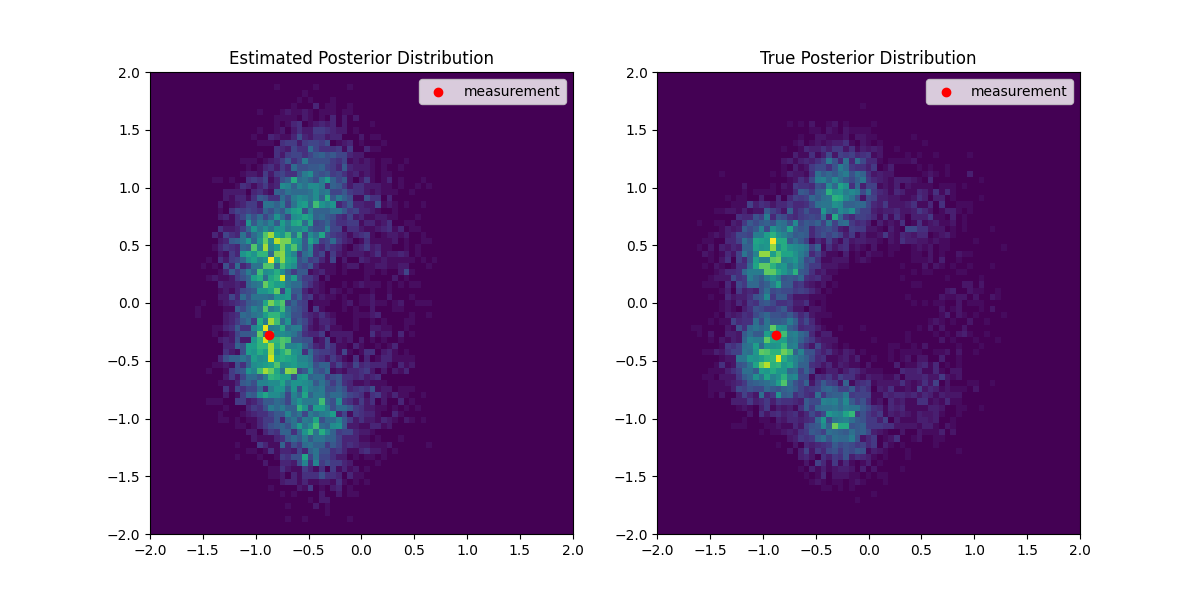

In [15]:
# compare posterior
n_samples = 10000
bins = 75
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 1}
x_t = torch.randn(n_samples,2).to(device)
traj = guided_ddim_sampler(denoiser, y,ddim_config , x_t, likelihood_weight=0.0025)
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
hist = axs[0].hist2d(traj[-1][:,0], traj[-1][:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].legend(['measurement'])

# Plot true posterior distribution
axs[1].set_title('True Posterior Distribution')
hist = axs[1].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])

plt.show()
# compute Wasserstein distance of posterior samples and true posterior
estimated_samples = traj[-1]



In [26]:
def compute_WD(ground_truth_samples, estimated_samples):
    bins = 75
    H1, x_edges, y_edges = np.histogram2d(ground_truth_samples[:, 0], ground_truth_samples[:, 1], bins=bins, range=[[-1.5, 1.5], [-1.5, 1.5]])
    H2, _, _ = np.histogram2d(estimated_samples[:, 0], estimated_samples[:, 1], bins=bins, range=[[-1.5, 1.5], [-1.5, 1.5]])
    # normalize
    H1 = H1 / np.sum(H1)
    H2 = H2 / np.sum(H2)
    # Create cost matrix for the binned data
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Bin centers for x
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])  # Bin centers for y

    # Create a grid of centers
    X, Y = np.meshgrid(x_centers, y_centers)

    # Flatten the grid to match flattened histograms
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)

    # Compute pairwise squared distances between all grid points
    cost_matrix = np.linalg.norm(grid_points[:, None, :] - grid_points[None, :, :], axis=2)


    wasserstein_distance_histogram = emd2(H1.flatten(), H2.flatten(), cost_matrix)
    return wasserstein_distance_histogram

In [27]:
wd_distances = []
for y in y_measurements:
    # compare posterior
    n_samples = 10000
    bins = 75
    ddim_config = {'n_ddim_steps': 100, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.0}
    
    x_t = torch.randn(n_samples,2).to(device)
    traj = guided_ddim_sampler(denoiser, y,ddim_config , x_t)
    # sample from true posterior
    ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
    # histogram
    wasserstein_distance_histogram = compute_WD(ground_truth_samples, traj[-1])
    print("Wasserstein Distance on Binned Data:", wasserstein_distance_histogram)
    wd_distances.append(wasserstein_distance_histogram)
wd_distances = np.array(wd_distances)
print("Mean Wasserstein Distance:", np.mean(wd_distances))


Wasserstein Distance on Binned Data: 0.21339977514806932
Wasserstein Distance on Binned Data: 0.21198582219175044
Wasserstein Distance on Binned Data: 0.17821415932983783
Wasserstein Distance on Binned Data: 0.2316897828067083
Wasserstein Distance on Binned Data: 0.25180192002608
Wasserstein Distance on Binned Data: 0.24792776938844846
Wasserstein Distance on Binned Data: 0.2514869114446322
Wasserstein Distance on Binned Data: 0.2688816793970732
Wasserstein Distance on Binned Data: 0.25899647404686366
Wasserstein Distance on Binned Data: 0.25879098994710786
Wasserstein Distance on Binned Data: 0.2557230939520315
Wasserstein Distance on Binned Data: 0.2344614368853268
Wasserstein Distance on Binned Data: 0.20527292764515745
Wasserstein Distance on Binned Data: 0.16019997256239785
Wasserstein Distance on Binned Data: 0.23157501792013235
Wasserstein Distance on Binned Data: 0.16481103966962868
Wasserstein Distance on Binned Data: 0.1680043132351398
Wasserstein Distance on Binned Data: 0.1

In [20]:
# flow matching posterior
def guided_flow_sampler(model, y, config, x_t, save_traj=False):
    if x_t is None:
        x_t = torch.randn(1,2).to(device)
    n_steps = config['n_steps']
    likelihood_weight = config['likelihood_weight']
    timesteps = np.linspace(0, 1, n_steps)
    if save_traj:
        traj = [x_t.detach().cpu().numpy()]
    with torch.no_grad():
        for i, (t_prev, t_curr) in enumerate(zip(timesteps[:-1], timesteps[1:])):
            v_pred = model(torch.cat([x_t, torch.ones(x_t.shape[0],1).to(device)*t_curr], 1))
            dt = t_curr - t_prev
            with torch.enable_grad():
                x_t.requires_grad_()
                y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_t.T).T
                loss = torch.sum((y_generated - y)**2)
                loss.backward()
                gradients = x_t.grad
            x_t = x_t + dt * v_pred - gradients * likelihood_weight
            if save_traj:
                traj.append(x_t.detach().cpu().numpy())
    return traj if save_traj else [x_t.detach().cpu().numpy()]



Text(0.5, 1.0, 'Density and Trajectory Flow Matching')

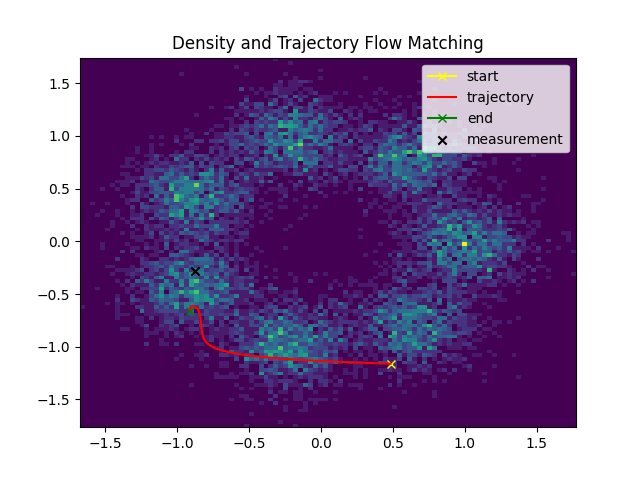

In [21]:
# plot trajecotry of one point
config = {'n_steps': 1000, 'likelihood_weight': 0.01}
n_samples = 10000
bins = 75
x_t = torch.randn(1,2).to(device)

traj = guided_flow_sampler(denoiser_flow, y, config, x_t, save_traj=True)
plt.figure()
plt.title('Density and Trajectory')
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)
plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# plot meaasurement y
plt.scatter(y[0,0].detach().cpu().numpy(),y[0,1].detach().cpu().numpy(), color='black', marker='x')
# add legend
plt.legend(['start','trajectory','end', 'measurement'])
# name
plt.title(f'Density and Trajectory Flow Matching')


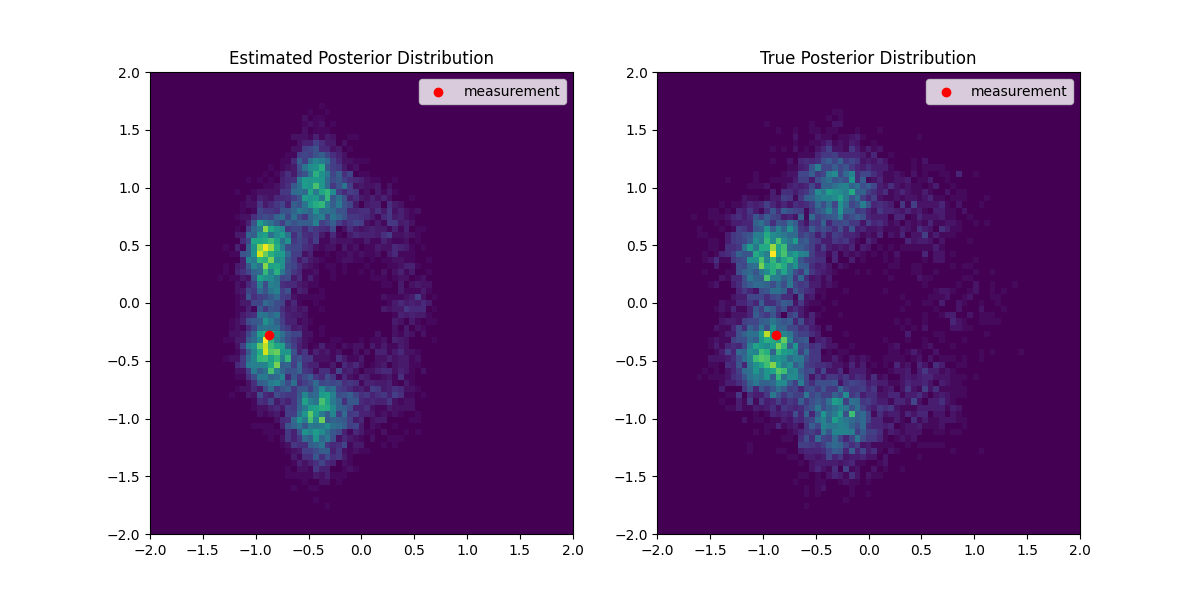

In [35]:
# compare posterior
config = {'n_steps': 100, 'likelihood_weight': 0.004}
n_samples = 10000
bins = 75
x_t = torch.randn(n_samples,2).to(device)
y = y_measurements[:1]
x_0 = guided_flow_sampler(denoiser_flow, y, config, x_t)[-1]
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title('Estimated Posterior Distribution')
hist = axs[0].hist2d(x_0[:,0], x_0[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].legend(['measurement'])
axs[1].set_title('True Posterior Distribution')
hist = axs[1].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])
plt.show()


In [36]:
# measure Wasserstein distance flow matching
wd_distances = []
for y in y_measurements:
    # compare posterior
    n_samples = 10000
    x_t = torch.randn(n_samples,2).to(device)
    x_0 = guided_flow_sampler(denoiser_flow, y, config, x_t)[-1]
    # sample from true posterior
    ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
    # histogram
    wasserstein_distance_histogram = compute_WD(ground_truth_samples, traj[-1])
    print("Wasserstein Distance on Binned Data:", wasserstein_distance_histogram)
    wd_distances.append(wasserstein_distance_histogram)
wd_distances = np.array(wd_distances)
print("Mean Wasserstein Distance:", np.mean(wd_distances))

Wasserstein Distance on Binned Data: 1.106688775941539
Wasserstein Distance on Binned Data: 1.1884454992031
Wasserstein Distance on Binned Data: 0.33177590244000654
Wasserstein Distance on Binned Data: 0.34684830021755775
Wasserstein Distance on Binned Data: 0.4865113150334996
Wasserstein Distance on Binned Data: 0.5232390404130772
Wasserstein Distance on Binned Data: 0.5777654999787857
Wasserstein Distance on Binned Data: 0.5035244863291326
Wasserstein Distance on Binned Data: 0.869682706335832
Wasserstein Distance on Binned Data: 0.38037259226621345
Wasserstein Distance on Binned Data: 0.7871811940545563
Wasserstein Distance on Binned Data: 1.0404318004869142
Wasserstein Distance on Binned Data: 1.2088612746804823
Wasserstein Distance on Binned Data: 1.3443005394144367
Wasserstein Distance on Binned Data: 0.2696038931644284
Wasserstein Distance on Binned Data: 0.36903727588880236
Wasserstein Distance on Binned Data: 1.318656832983207
Wasserstein Distance on Binned Data: 1.51662149820

KeyboardInterrupt: 

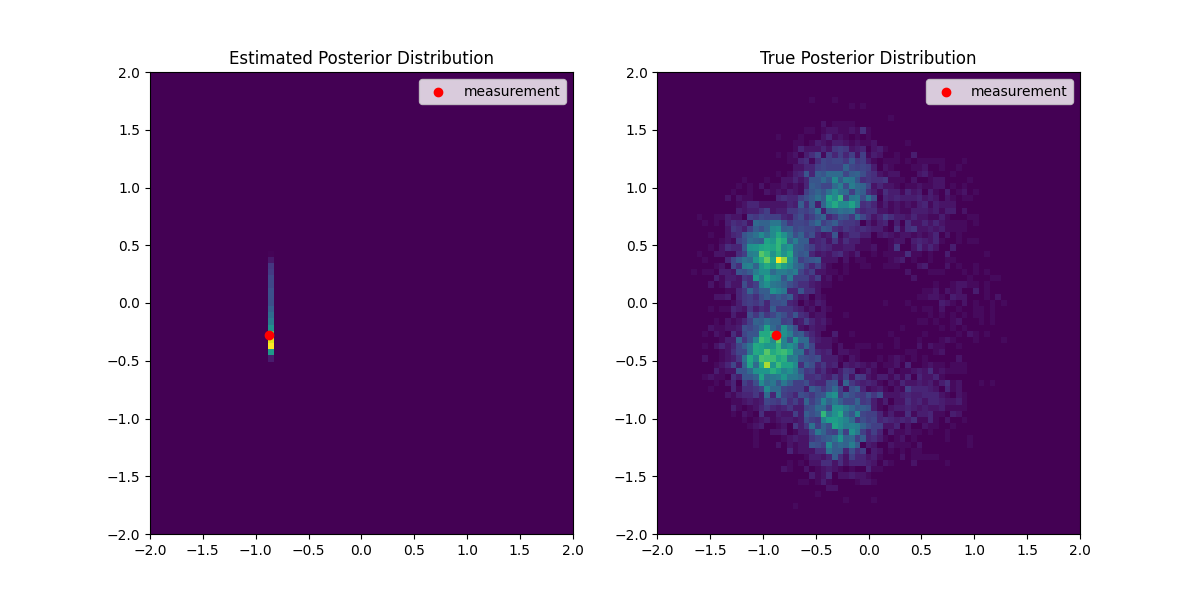

In [42]:
# variational inference DDIM T -> 0
n_samples = 10000
bins = 75
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.5, "likelihood_weight": 0.01, "regularizer_weight": 0.1}
x_t = torch.randn(n_samples,2).to(device)
y = y_measurements[:1]
x_mu = x_t
x_sigma = torch.ones_like(x_t)
save_traj = False
n_ddim_steps = ddim_config['n_ddim_steps']
n_steps = ddim_config['n_steps']
eta = ddim_config['eta']
regularizer_weight = ddim_config['regularizer_weight']
likelihood_weight = ddim_config['likelihood_weight']
skip = int(n_steps/n_ddim_steps)
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
if save_traj:
    traj = [x_t.detach().cpu().numpy()]
for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
    with torch.no_grad():
        eta_t = (1 + x_sigma**2* (alpha_cumprod[t]/(1-alpha_cumprod[t]))**2)**0.5
        a_t = alpha_cumprod[t]
        a_t_next = alpha_cumprod[t_next]
        eps = torch.randn(x_mu.shape[0],2).to(device)
        x_t = alpha_cumprod[t,None] * x_mu + eps * (1-alpha_cumprod[t,None])
        eps_pred = denoiser(torch.cat([x_t, torch.ones(x_t.shape[0],1).to(device)*t/1000], 1))
        # eps_pred = denoiser(x_t, torch.ones(x_t.shape[0]).to(device)*t)
        dmu_reg = (eps_pred) * (1-alpha_cumprod[t])/alpha_cumprod[t]
        # dsig_reg = 2 * 1/eta_t * (1-alpha_cumprod[t])/alpha_cumprod[t] * eps.T @ (eps_pred - eta_t * eps)**2 
        with torch.enable_grad():
            x_mu.requires_grad_()
            x_sigma.requires_grad_()
            y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_mu.T).T
            loss = torch.sum((y_generated - y)**2, dim=1)
            loss.backward(torch.ones_like(loss))
            gradients_mu = x_mu.grad
            gradients_sigma = x_sigma.grad
        # data term
        x_mu = x_mu - likelihood_weight *  gradients_mu - regularizer_weight * dmu_reg
        # x_sigma = x_sigma - regularizer_weight * dsig_reg - likelihood_weight * gradients_sigma
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
hist = axs[0].hist2d(x_mu[:,0], x_mu[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].legend(['measurement'])

# Plot true posterior distribution
axs[1].set_title('True Posterior Distribution')
hist = axs[1].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])


plt.show()
# compute Wasserstein distance of posterior samples and true posterior
estimated_samples = traj[-1]


  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/jl/3dg2_4_119d9bmblgpt2b_gc0000gn/T/ipykernel_5903/4262534937.py:52: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eps_pred = denoiser(torch.cat([x_t, (torch.ones(x_t.shape[0],1).to(device)*t[:,None]/1000).float()], 1))
100%|██████████| 1000/1000 [00:14<00:00, 67.10it/s]


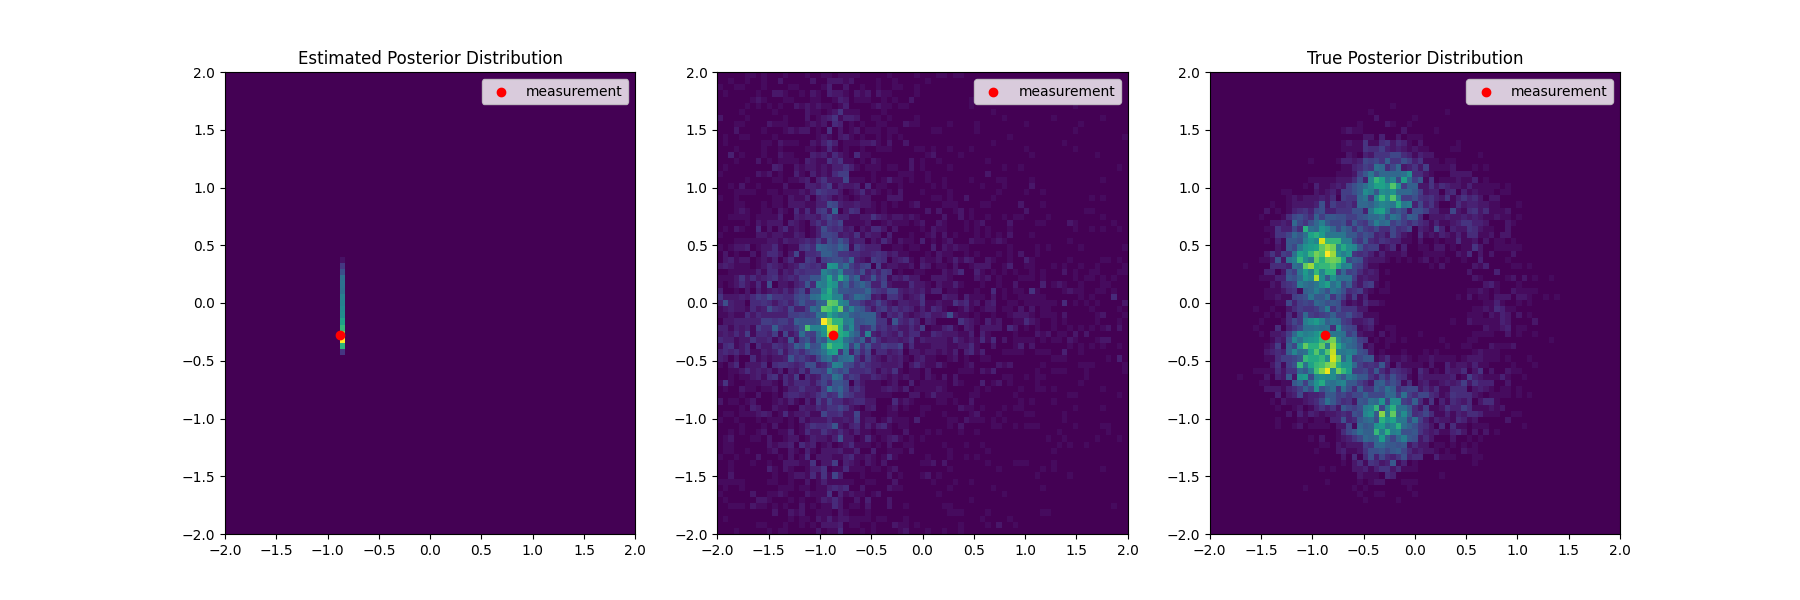

In [44]:
# variational inference DDIM: > random sampling
batch_size = 4
n_particles = 10000
n_samples = 10000
bins = 75
n_iterations= 1000
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.5, "likelihood_weight": 0.01, "regularizer_weight": 0.1}
x_t = torch.randn(batch_size, n_particles,2).to(device)
y = y_measurements[:1]
x_mu = x_t[0]
x_t = x_t.reshape(-1,2)
x_sigma = torch.randn_like(x_mu).to(device)** 2 
save_traj = False
n_ddim_steps = ddim_config['n_ddim_steps']
n_steps = ddim_config['n_steps']
eta = ddim_config['eta']
regularizer_weight = ddim_config['regularizer_weight']
likelihood_weight = ddim_config['likelihood_weight']
regularizer_weight_sig = 0.001
likelihood_weight_sig = 0.001
skip = int(n_steps/n_ddim_steps)
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
if save_traj:
    traj = [x_t.detach().cpu().numpy()]
for i in tqdm(range(n_iterations)):
    with torch.no_grad():
        start_idx = int(i * (n_steps-1) // n_iterations)
        t_index = torch.randint(start_idx, n_steps-1, (batch_size*n_particles,))
        t = timesteps[t_index]
        t_next = timesteps[t_index+1]
        alpha_cumprod_t = alpha_cumprod[t][:,None]
        eta_t = (1 + x_sigma.repeat(batch_size,1)**2* (alpha_cumprod[t, None]/(1-alpha_cumprod[t,None]))**2)**0.5
        

        with torch.enable_grad():
            x_mu.requires_grad_()
            x_sigma.requires_grad_()
            # sample x0
            x0 = x_mu #+ x_sigma * torch.randn_like(x_mu)
            y_generated = (torch.Tensor(measurement_model.A).to(device) @ x0.T).T
            loss = torch.sum((y_generated - y)**2, dim=1)
            loss.backward(torch.ones_like(loss))
            gradients_mu = x_mu.grad
            gradients_sigma = x_sigma.grad
        # repeat x0 along batch dimension batch_size times
        x0 = x0.repeat(batch_size,1)
        eps = torch.randn(batch_size*n_particles,2).to(device)
        x_t = alpha_cumprod_t * x0 + eps * (1-alpha_cumprod_t)
        eps_pred = denoiser(torch.cat([x_t, (torch.ones(x_t.shape[0],1).to(device)*t[:,None]/1000).float()], 1))
        # eps_pred = denoiser(x_t, torch.from_numpy(t).to(device))
        dmu_reg = (eps_pred) * (1-alpha_cumprod_t)/alpha_cumprod_t
        # compute diagonal bxd of jacobian matrix bxdxd
        jacobian_diagonal = x_sigma.repeat(batch_size,1) * 1/eta_t * (alpha_cumprod_t**2)/(1-alpha_cumprod_t) * eps
        dsig_reg = jacobian_diagonal * (eps_pred - 1/eta_t * eps)
        dsig_reg = dsig_reg.reshape(batch_size, n_particles, 2)
        dsig_reg = dsig_reg.mean(dim=0)
        dmu_reg = dmu_reg.reshape(batch_size, n_particles, 2)
        dmu_reg = dmu_reg.mean(dim=0)
        # data term
        loss = (dmu_reg**2).mean() + loss.mean()
        x_mu = x_mu - likelihood_weight *  gradients_mu - regularizer_weight * dmu_reg
        x_sigma = x_sigma - regularizer_weight_sig * dsig_reg #- likelihood_weight_sig * gradients_sigma
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
# generate samples from estimated posterior
x_samples = x_mu + torch.randn_like(x_mu) * x_sigma
hist = axs[0].hist2d(x_mu[:,0], x_mu[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].legend(['measurement'])

hist = axs[1].hist2d(x_samples[:,0], x_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])

# Plot true posterior distribution
axs[2].set_title('True Posterior Distribution')
hist = axs[2].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[2].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[2].legend(['measurement'])
# get most frequent value of posterior
plt.show()
# compute Wasserstein distance of posterior samples and true posterior
estimated_samples = traj[-1]


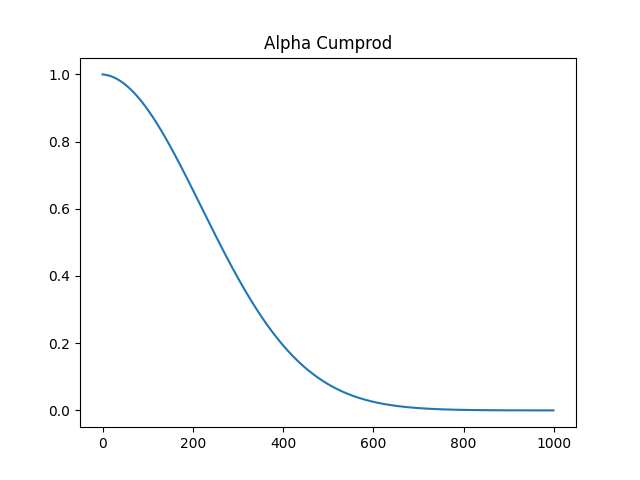

  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/jl/3dg2_4_119d9bmblgpt2b_gc0000gn/T/ipykernel_5903/101474642.py:68: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  eps_pred = denoiser(torch.cat([x_t, (torch.ones(x_t.shape[0],1).to(device)*t[:,None]/1000).float()], 1))
100%|██████████| 10000/10000 [00:03<00:00, 3314.89it/s]


mu: tensor([[-0.8537,  0.3455],
        [-0.8933, -0.4243],
        [-0.8488,  0.3656],
        [-0.8461, -0.5696]]) sigma: tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


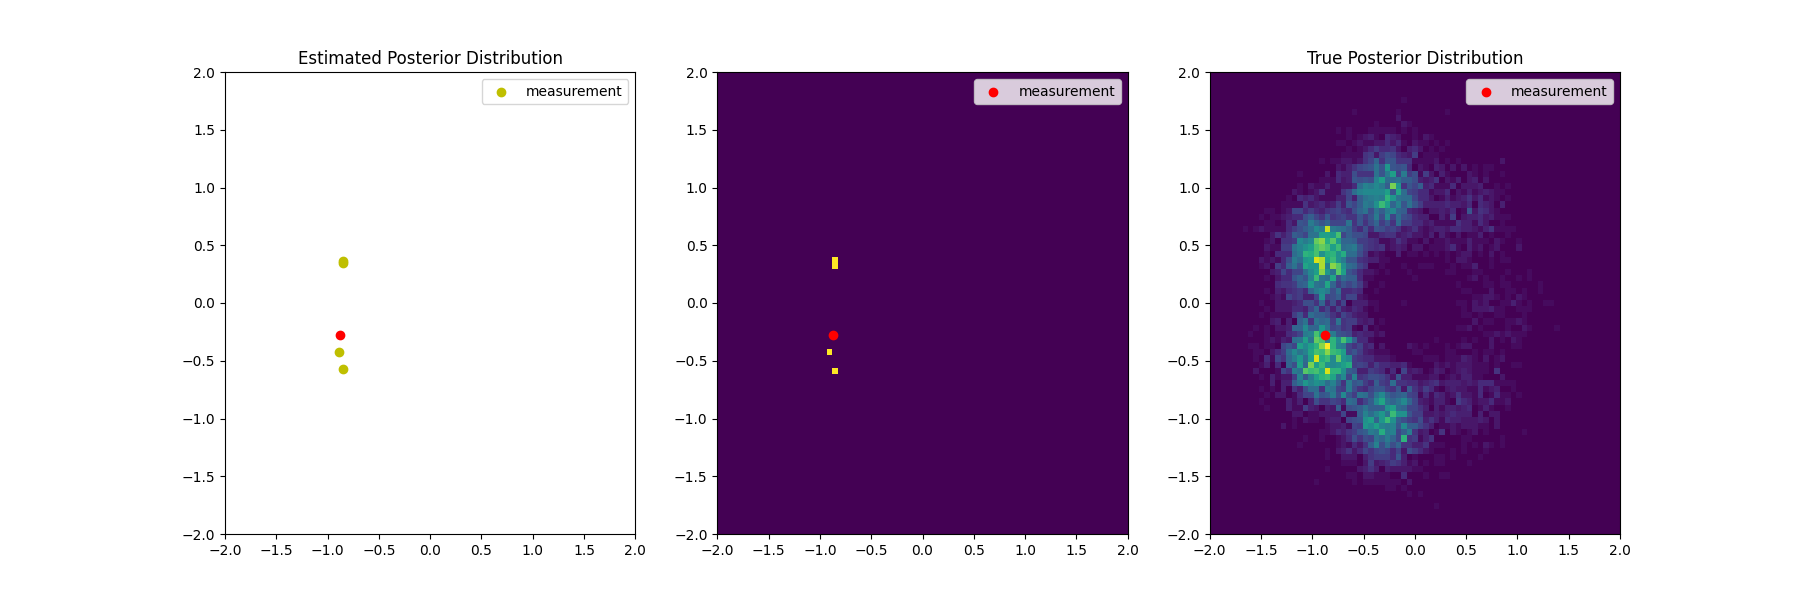

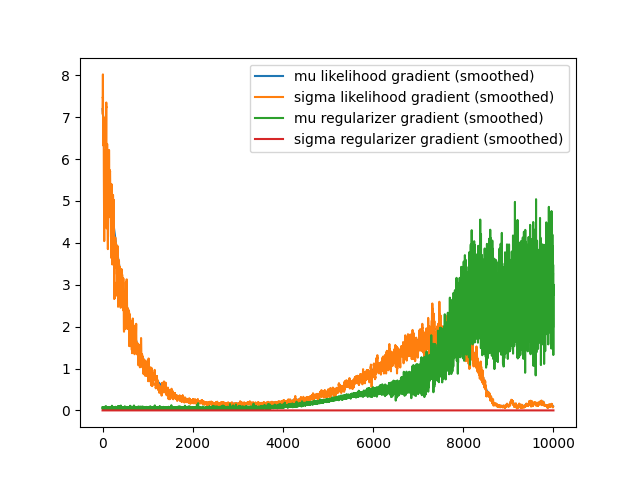

In [79]:
# variational inference DDIM: > random sampling
batch_size = 1
n_particles = 4
n_samples = 10000
bins = 75
n_iterations= 10000
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.5, "likelihood_weight": 1e-3, "regularizer_weight": 4e-3}
x_t = torch.randn(batch_size, n_particles,2).to(device)
y = y_measurements[:1]
x_mu = x_t[0]
x_t = x_t.reshape(-1,2)
x_sigma = torch.randn_like(x_mu).to(device)** 2 *0 
save_traj = False
n_ddim_steps = ddim_config['n_ddim_steps']
n_steps = ddim_config['n_steps']
eta = ddim_config['eta']
regularizer_weight = ddim_config['regularizer_weight']
likelihood_weight = ddim_config['likelihood_weight']
regularizer_weight_sig = 1
likelihood_weight_sig = 0e-3
skip = int(n_steps/n_ddim_steps)
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
# use adam optimizer
optimizer = torch.optim.Adam([x_mu, x_sigma], lr=1e-3)
if save_traj:
    traj = [x_t.detach().cpu().numpy()]
x_mu_grad_likelihood = []
x_sigma_grad_likelihood = []
x_sigma_grad_regularizer = []
x_mu_grad_regularizer = []
for i in tqdm(range(n_iterations)):
    with torch.no_grad():
        start_idx = int(i * (n_steps-1) // n_iterations)
        t_index = torch.randint(start_idx, n_steps-1, (batch_size*n_particles,))
        t_index = (n_steps-1) * i // n_iterations
        # repeat 
        t_index = torch.Tensor([t_index]).repeat(batch_size*n_particles).type(torch.int64).to(device)
        # if i < n_iterations//2:
        #     t_index = torch.randint(int((n_steps-1)*0.2), int((n_steps-1)* 0.98), (batch_size*n_particles,))
        # else:
        #     t_index = torch.randint(n_steps//2, int((n_steps-1)* 0.98), (batch_size*n_particles,))
        # t_index = torch.randint(0, n_steps-1, (batch_size*n_particles,))
        t = timesteps[t_index]
        t_next = timesteps[t_index+1]
        alpha_cumprod_t = alpha_cumprod[t][:,None]

        with torch.enable_grad():
            optimizer.zero_grad()
            x_mu.requires_grad_()
            x_sigma.requires_grad_()
            # sample x0
            eta_t = (1 + x_sigma.repeat(batch_size,1)**2* (alpha_cumprod[t, None]/(1-alpha_cumprod[t,None]))**2)**0.5
            x0 = x_mu.repeat(batch_size,1) + x_sigma.repeat(batch_size,1) * torch.randn(batch_size*n_particles,2)
            y_generated = (torch.Tensor(measurement_model.A).to(device) @ x0.T).T
            loss = (y_generated - y)**2
            loss = loss.reshape(batch_size, n_particles, 2).mean(dim=0)
            loss.backward(torch.ones_like(loss))
            gradients_mu = x_mu.grad
            gradients_sigma = x_sigma.grad
            # repeat x0 along batch dimension batch_size times
            x0 = x0.repeat(batch_size,1)
            eps = torch.randn(batch_size*n_particles,2).to(device)
            x_t = alpha_cumprod_t * x_mu.repeat(batch_size,1) + eps * eta_t*(1-alpha_cumprod_t)
            
            eps_pred = denoiser(torch.cat([x_t, (torch.ones(x_t.shape[0],1).to(device)*t[:,None]/1000).float()], 1))
            dmu_reg = (eps_pred - 1/eta_t*eps) #* (1-alpha_cumprod_t)/alpha_cumprod_t
            dmu_reg = dmu_reg.reshape(batch_size, n_particles, 2)
            dmu_reg = dmu_reg.mean(dim=0)
            # compute diagonal bxd of jacobian matrix bxdxd
            jacobian_diagonal = x_sigma.repeat(batch_size,1) * 1/eta_t * (alpha_cumprod_t**2)/(1-alpha_cumprod_t) * eps
            dsig_reg = jacobian_diagonal * (eps_pred - 1/eta_t * eps) #* (1-alpha_cumprod_t)/alpha_cumprod_t
            dsig_reg = dsig_reg.reshape(batch_size, n_particles, 2)
            dsig_reg = dsig_reg.mean(dim=0)
            
            # data term sigma_reg + mu_reg + dataterm
            # total_loss = regularizer_weight * (dsig_reg.detach() * x_sigma + dmu_reg.detach() * x_mu) + loss * likelihood_weight
            # total_loss.backward(torch.ones_like(total_loss))
            x_mu_grad_likelihood.append(torch.norm(x_mu.grad).item())
            x_sigma_grad_likelihood.append(torch.norm(x_sigma.grad).item())
            x_mu_grad_regularizer.append(torch.norm(dmu_reg).item())
            x_sigma_grad_regularizer.append(torch.norm(dsig_reg).item())
        x_mu = x_mu - likelihood_weight *  gradients_mu - regularizer_weight * dmu_reg
        x_sigma = x_sigma - regularizer_weight_sig * dsig_reg - likelihood_weight_sig * gradients_sigma
            # optimizer.step()
        
        # log gradient norms
        
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
print(f"mu: {x_mu} sigma: {x_sigma}")
# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
# generate samples from estimated posterior
x_samples = x_mu[:,None] + torch.randn(n_particles, n_samples,2) * x_sigma[:,None]
x_samples = x_samples.reshape(-1,2).detach().cpu().numpy()
axs[0].scatter(x_mu[:,0].detach().cpu().numpy(), x_mu[:,1].detach().cpu().numpy(), c='y')
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].set_xlim([-2, 2])
axs[0].set_ylim([-2, 2])
axs[0].legend(['measurement'])

hist = axs[1].hist2d(x_samples[:,0], x_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])

# Plot true posterior distribution
axs[2].set_title('True Posterior Distribution')
hist = axs[2].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[2].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[2].legend(['measurement'])
# get most frequent value of posterior
plt.show()

plt.figure()
x_mu_grad_likelihood = np.convolve(x_mu_grad_likelihood, np.ones(10)/10, mode='valid')
x_sigma_grad_likelihood = np.convolve(x_sigma_grad_likelihood, np.ones(10)/10, mode='valid')
plt.plot(x_mu_grad_likelihood, label='mu likelihood gradient (smoothed)')
plt.plot(x_sigma_grad_likelihood, label='sigma likelihood gradient (smoothed)')
plt.plot(x_mu_grad_regularizer, label='mu regularizer gradient (smoothed)')
plt.plot(x_sigma_grad_regularizer, label='sigma regularizer gradient (smoothed)')
plt.legend()
plt.show()


In [71]:
(1-alpha_cumprod[-1])/alpha_cumprod[-1]

tensor(24777.0488)